In [9]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv("../data/amazon_fashion.csv") # cleaned dataset
df

,rating,title,text,helpful_vote,verified_purchase,asin,user_id
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,3,True,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ
1,5.0,A,Great,0,True,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,3,True,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,2,True,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over ...,0,True,B00PKRFU4O,AHSPLDNW5OOUK2PLH7GXLACFBZNQ
...,...,...,...,...,...,...,...
2500934,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,0,True,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ
2500935,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,0,True,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ
2500936,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,0,True,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ
2500937,5.0,Awesome,Great product.,1,True,B00YGFMQC0,AGZ6IIYSPCW4YXWH6VFEOI7MTBZA


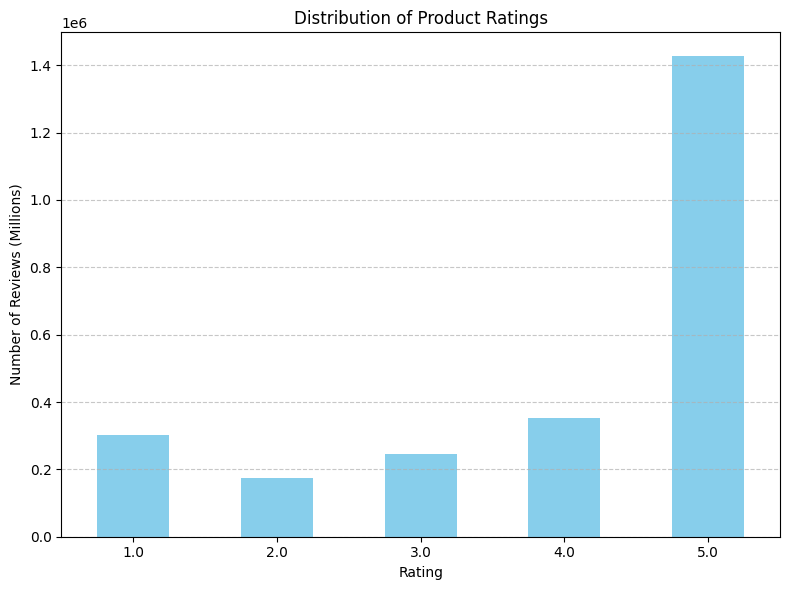

In [12]:
import matplotlib.pyplot as plt

# Calculate the frequency of each rating
rating_counts = df['rating'].value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews (Millions)')
plt.xticks(rotation=0) # Ensure rating labels are horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

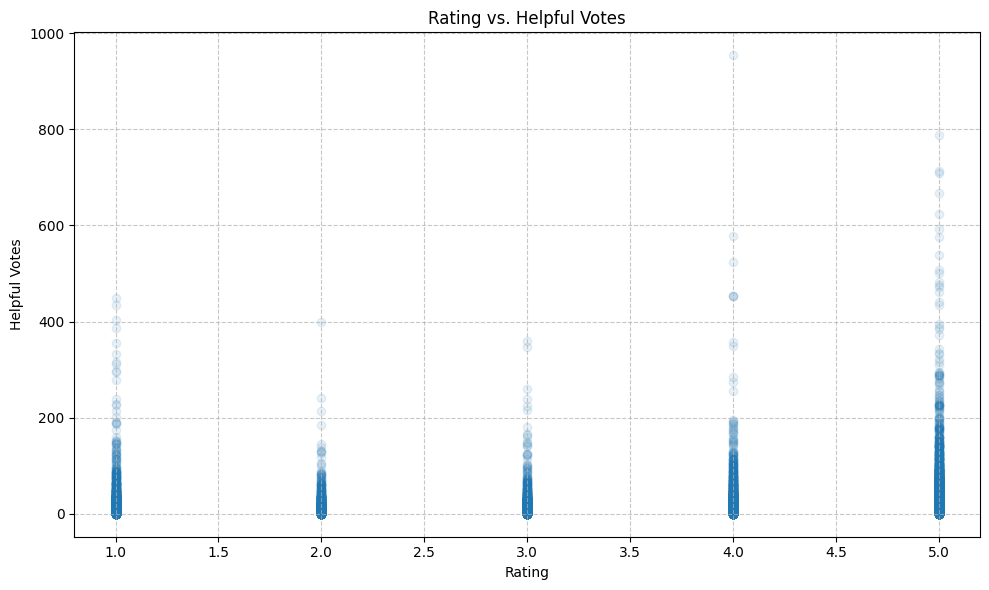

In [13]:
# Check if 'helpful_votes' column exists. If not, create a dummy one for demonstration.
# In a real scenario, you would ensure your DataFrame contains the actual 'helpful_votes' column.
# Plotting Rating (x) and Helpful Votes (y)
plt.figure(figsize=(10, 6))
# Using a scatter plot to visualize the relationship between individual ratings and helpful votes.
# Given the large number of data points (2.5 million), a low alpha value helps visualize density.
plt.scatter(df['rating'], df['helpful_vote'], alpha=0.1)
plt.title('Rating vs. Helpful Votes')
plt.xlabel('Rating')
plt.ylabel('Helpful Votes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
average_helpful_votes_by_rating = df.groupby('rating')['helpful_vote'].mean()
print("Average helpful votes for each rating:")
print(average_helpful_votes_by_rating)


Average helpful votes for each rating:
rating
1.0    0.613409
2.0    0.511213
3.0    0.514635
4.0    0.625516
5.0    0.556477
Name: helpful_vote, dtype: float64


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'df' is already loaded and available from previous cells.
# We will use the 'text' column as the text feature and 'rating' as the target.

# 1. Prepare the data
# Fill any potential NaN values in 'text' with an empty string to prevent errors during vectorization.
df['text'] = df['text'].fillna('')

X = df['text']
y = df['rating']

# 2. Split the data into training and testing sets
# Using stratify=y ensures that the proportion of target classes (ratings) is the same in both train and test sets.
# A test_size of 0.2 (20%) is common and appropriate for large datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data size: {len(X_train)} samples")
print(f"Test data size: {len(X_test)} samples")

# 3. Create a pipeline for text feature extraction and classification
# TfidfVectorizer converts text into a matrix of TF-IDF features.
#   - stop_words='english' removes common English words that don't add much meaning.
#   - max_features=10000 limits the vocabulary size for performance and to reduce noise.
# LinearSVC is a linear support vector classifier, suitable for text classification.
#   - random_state for reproducibility.
#   - dual=False is recommended when n_samples > n_features, which is the case here (2M samples vs 10K features).
text_classifier_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('svc', LinearSVC(random_state=42, dual=False))
])

# 4. Train the model
print("\nTraining LinearSVC model... This may take a significant amount of time due to the dataset size.")
text_classifier_pipeline.fit(X_train, y_train)
print("Model training complete.")

# 5. Make predictions on the test set for evaluation
y_test_pred = text_classifier_pipeline.predict(X_test)

# 6. Evaluate the model
print("\n--- Model Evaluation (on Test Set) ---")
print("Accuracy Score:", accuracy_score(y_test, y_test_pred))
# The classification report provides precision, recall, and f1-score for each class.
# zero_division=0 handles cases where a class has no predicted samples, preventing warnings.
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, zero_division=0))

# 7. Add predicted rating into a new column for the entire DataFrame
print("\nGenerating predictions for the entire dataset and adding to 'df' as 'predicted_rating'...")
# Predict on the full 'text' column (X) to get predictions for all rows in df
df['predicted_rating'] = text_classifier_pipeline.predict(X)
print("Predicted ratings added to 'df'.")

# Optional: Display a few predictions vs actual ratings from the full DataFrame
print("\n--- Sample Predictions vs Actual Ratings (from full df) ---")
# Now that 'predicted_rating' is in df, we can sample directly from df
sample_df_with_predictions = df[['rating', 'predicted_rating']].sample(5, random_state=42)
print(sample_df_with_predictions)


Training data size: 2000751 samples
Test data size: 500188 samples

Training LinearSVC model... This may take a significant amount of time due to the dataset size.
Model training complete.

--- Model Evaluation (on Test Set) ---
Accuracy Score: 0.6840328036658216

Classification Report:
               precision    recall  f1-score   support

         1.0       0.56      0.76      0.64     60682
         2.0       0.31      0.02      0.05     34692
         3.0       0.39      0.18      0.25     49094
         4.0       0.44      0.18      0.25     70466
         5.0       0.75      0.96      0.84    285254

    accuracy                           0.68    500188
   macro avg       0.49      0.42      0.41    500188
weighted avg       0.62      0.68      0.62    500188


Generating predictions for the entire dataset and adding to 'df' as 'predicted_rating'...
Predicted ratings added to 'df'.

--- Sample Predictions vs Actual Ratings (from full df) ---
         rating  predicted_rating
566

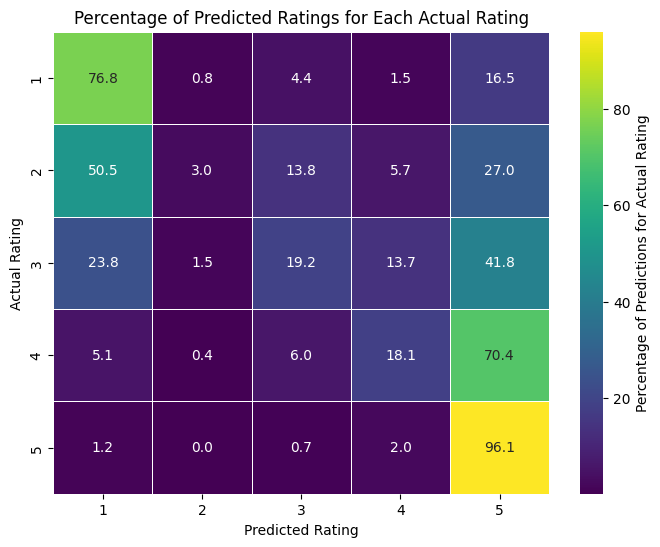

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a contingency table (cross-tabulation) of actual vs. predicted ratings.
# Convert ratings to integers to ensure discrete categories for the plot.
contingency_table = pd.crosstab(df['rating'].astype(int), df['predicted_rating'].astype(int))

# Calculate percentages: for each actual rating (row), what percentage of predictions
# fell into each predicted rating category.
# The `normalize='index'` argument ensures that each row sums to 1 (or 100%).
percentage_table = pd.crosstab(df['rating'].astype(int), df['predicted_rating'].astype(int), normalize='index') * 100

# Plot the percentage table as a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(
    percentage_table,
    annot=True,  # Show the percentage in each cell
    fmt='.1f',   # Format annotations as floating point numbers with one decimal place
    cmap='viridis', # Choose a color map
    linewidths=.5, # Add lines between cells for better separation
    cbar_kws={'label': 'Percentage of Predictions for Actual Rating'} # Label the color bar
)
plt.title('Percentage of Predicted Ratings for Each Actual Rating')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

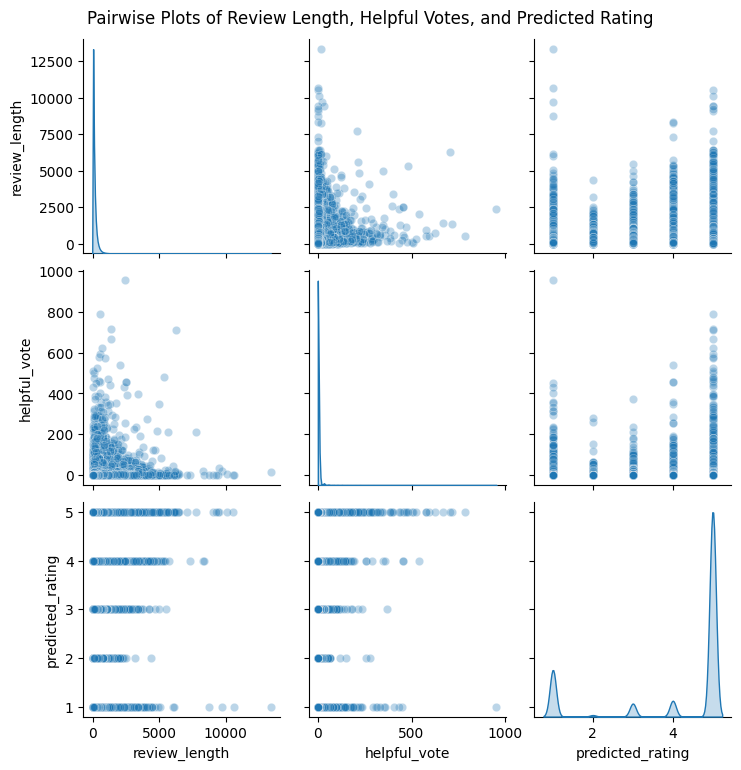

In [17]:
import numpy as np

# Calculate review length
# Ensure 'text' column exists and is of string type before applying len
if 'text' in df.columns and pd.api.types.is_string_dtype(df['text']):
    df['review_length'] = df['text'].apply(len)
else:
    print("Warning: 'text' column not found or not string type. Cannot calculate review_length.")
    # Create a dummy review_length if 'text' is missing, to allow the plot to proceed
    df['review_length'] = np.random.randint(50, 500, size=len(df))

# Select the columns for the pairplot
# Ensure 'predicted_rating' exists, as it was created in a previous cell.
plot_vars = ['review_length', 'helpful_vote', 'predicted_rating']
plot_df = df[plot_vars]

# Create the 3x3 grid of plots using seaborn.pairplot
# 'kind="scatter"' ensures scatter plots for off-diagonal relationships.
# 'diag_kind="kde"' shows the distribution of each variable on the diagonal,
# which is generally more informative than a scatter plot of a variable against itself (y=x line).
# 'plot_kws={'alpha': 0.3}' adds transparency to points, which is useful for large datasets
# to better visualize density.
g = sns.pairplot(plot_df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.3})

# Add a title to the entire figure
g.fig.suptitle('Pairwise Plots of Review Length, Helpful Votes, and Predicted Rating', y=1.02) # y adjusts title position

plt.show()


In [19]:
# Save the DataFrame to CSV
df.to_csv("../output/final_data.csv", index=False)